In [1]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG19, DenseNet121, InceptionV3, ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Path to the zip file and extraction folder
zip_path = r"C:\Users\Paidi Madhu\Downloads\archive (1).zip"
extract_dir = r"C:\Users\Paidi Madhu\Downloads\archive (1)_extracted"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

Dataset extracted to C:\Users\Paidi Madhu\Downloads\archive (1)_extracted


In [3]:
# Path to the extracted dataset
data_dir = r"C:\Users\Paidi Madhu\Downloads\archive (1)_extracted"
# Function to load images and labels
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):  # Assuming subfolders are 'COVID' and 'non-COVID'
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = Image.open(img_path)

                # Ensure all images are RGB (3 channels)
                img = img.convert("RGB")

                # Resize image to (75, 75)
                img = img.resize((224, 224))
                img = np.array(img)

                if img is not None:
                    images.append(img)
                    labels.append(label)  # Label could be 'COVID' or 'non-COVID'
    return np.array(images), np.array(labels)

# Load images and labels
X, Y = load_images_from_folder(data_dir)

# Normalize the images
X = X / 255.0  # Scaling pixel values between 0 and 1

print(f"Loaded {X.shape[0]} images")

Loaded 2481 images


In [4]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 1984
Validation set size: 497


In [5]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Convert 'COVID' and 'non-COVID' labels to numeric values (0 and 1)
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Check the transformation
print("Label encoding:", label_encoder.classes_)  # This should print ['COVID', 'non-COVID']

Label encoding: ['COVID' 'non-COVID']


In [6]:
# Data augmentation
data_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [7]:
import seaborn as sns

def evaluate_model(model, history, X_val, y_val_encoded, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Predictions
    y_pred = (model.predict(X_val) > 0.5).astype("int32")

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(y_val_encoded, y_pred)
    cr = classification_report(y_val_encoded, y_pred, target_names=label_encoder.classes_)

    # Display Confusion Matrix as Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("Classification Report:")
    print(cr)

    # Calculate Specificity and Selectivity
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # True Negatives / (True Negatives + False Positives)
    selectivity = tp / (tp + fn)   # True Positives / (True Positives + False Negatives)

    print(f"Specificity: {specificity:.4f}")
    print(f"Selectivity: {selectivity:.4f}")

In [10]:
# Function to build DenseNet model
def build_densenet():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    return model

# Train DenseNet Model
densenet_model = build_densenet()
densenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

history_densenet = densenet_model.fit(data_gen.flow(X_train, y_train_encoded, batch_size=32),
                                       validation_data=(X_val, y_val_encoded), epochs=10)

Epoch 1/10


C:\Users\Paidi Madhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1385s 21s/step - accuracy: 0.7660 - loss: 0.4763 - val_accuracy: 0.7404 - val_loss: 0.5714
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1087s 17s/step - accuracy: 0.9325 - loss: 0.1763 - val_accuracy: 0.8370 - val_loss: 0.4531
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 867s 14s/step - accuracy: 0.9529 - loss: 0.1297 - val_accuracy: 0.9356 - val_loss: 0.1678
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 868s 14s/step - accuracy: 0.9663 - loss: 0.1021 - val_accuracy: 0.9618 - val_loss: 0.1066
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1060s 16s/step - accuracy: 0.9770 - loss: 0.0752 - val_accuracy: 0.9457 - val_loss: 0.1331
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1010s 16s/step - accuracy: 0.9809 - loss: 0.0477 - val_accuracy: 0.9537 - val_loss: 0.1464
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1045s 17s/step - accuracy: 0.9742 - loss: 0.0679 - val_accuracy: 0.9577 - val_loss: 0.1068
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1113s 18s/step - accuracy: 0.9799 - loss: 0.0607 - val_accuracy: 0.9376 

In [11]:
train_accuracy = history_densenet.history['accuracy']
val_accuracy = history_densenet.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

Training Accuracy: 0.9838709831237793
Validation Accuracy: 0.9678068161010742


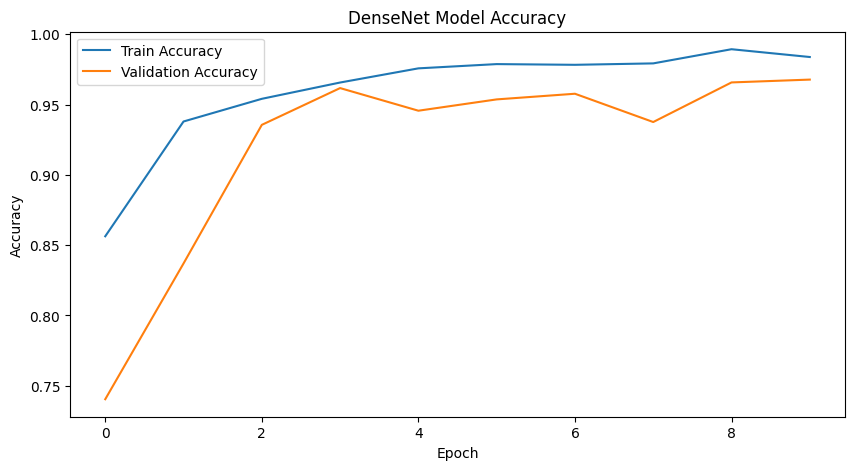

16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step


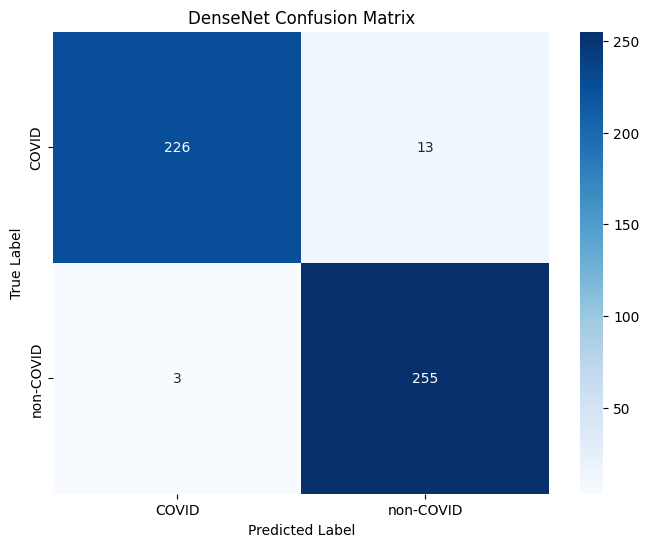

Classification Report:
              precision    recall  f1-score   support

       COVID       0.99      0.95      0.97       239
   non-COVID       0.95      0.99      0.97       258

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

Specificity: 0.9456
Selectivity: 0.9884
Model saved successfully.


In [12]:
# Evaluate DenseNet Model
evaluate_model(densenet_model, history_densenet, X_val, y_val_encoded, "DenseNet")

# Save the DenseNet model
densenet_model.save('densenet_covid_model.keras')
print("Model saved successfully.")

In [13]:
# Function to build InceptionV3 model
def build_inception():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    return model

# Train InceptionV3 Model
inception_model = build_inception()
inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

history_inception = inception_model.fit(data_gen.flow(X_train, y_train_encoded, batch_size=32),
                                        validation_data=(X_val, y_val_encoded), epochs=10)

Epoch 1/10


C:\Users\Paidi Madhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1028s 15s/step - accuracy: 0.7464 - loss: 0.4920 - val_accuracy: 0.6157 - val_loss: 1.5261
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1044s 17s/step - accuracy: 0.9213 - loss: 0.2037 - val_accuracy: 0.6237 - val_loss: 1.2094
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 842s 14s/step - accuracy: 0.9360 - loss: 0.1614 - val_accuracy: 0.6660 - val_loss: 1.2601
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 691s 11s/step - accuracy: 0.9574 - loss: 0.1040 - val_accuracy: 0.7143 - val_loss: 1.2948
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 709s 11s/step - accuracy: 0.9572 - loss: 0.1156 - val_accuracy: 0.7726 - val_loss: 0.7750
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 623s 10s/step - accuracy: 0.9627 - loss: 0.0973 - val_accuracy: 0.9014 - val_loss: 0.2400
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 770s 12s/step - accuracy: 0.9681 - loss: 0.0843 - val_accuracy: 0.9779 - val_loss: 0.0695
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 880s 14s/step - accuracy: 0.9822 - loss: 0.0497 - val_accuracy: 0.9779 - va

In [14]:
train_accuracy = history_inception.history['accuracy']
val_accuracy = history_inception.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

Training Accuracy: 0.9783266186714172
Validation Accuracy: 0.9476861357688904


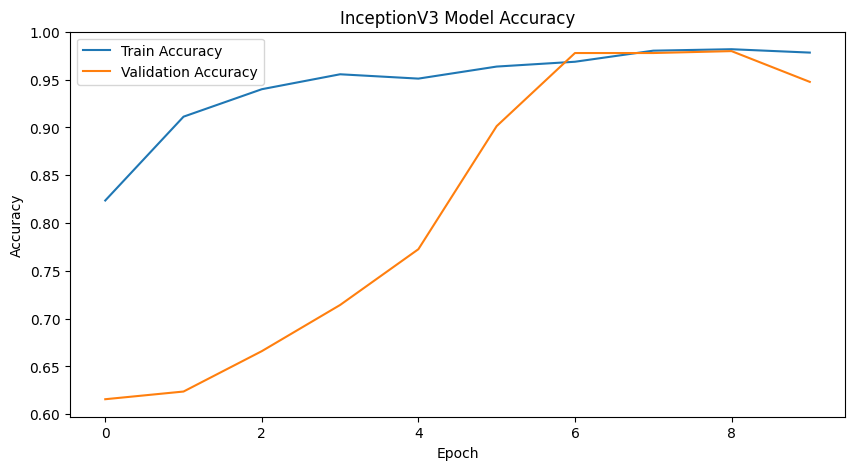

16/16 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step


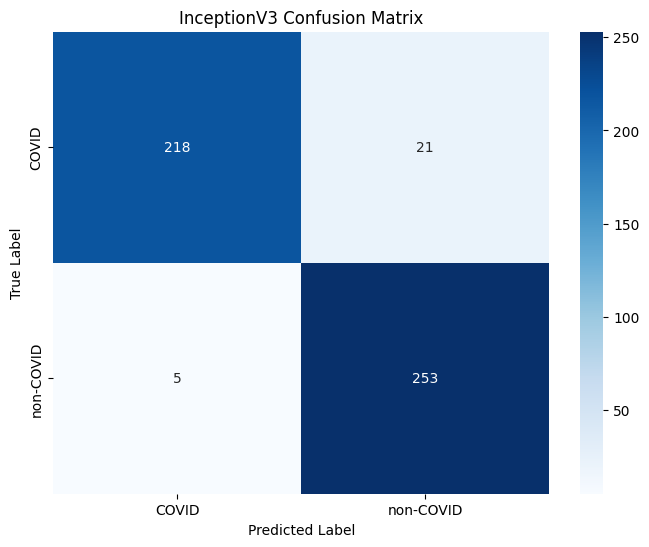

Classification Report:
              precision    recall  f1-score   support

       COVID       0.98      0.91      0.94       239
   non-COVID       0.92      0.98      0.95       258

    accuracy                           0.95       497
   macro avg       0.95      0.95      0.95       497
weighted avg       0.95      0.95      0.95       497

Specificity: 0.9121
Selectivity: 0.9806
Model saved successfully.


In [15]:
# Evaluate InceptionV3 Model
evaluate_model(inception_model, history_inception, X_val, y_val_encoded, "InceptionV3")

# Save the InceptionV3 model
inception_model.save('inception_covid_model.keras')
print("Model saved successfully.")

In [16]:
# Function to build ResNet model
def build_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    return model

# Train ResNet Model
resnet_model = build_resnet()
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

history_resnet = resnet_model.fit(data_gen.flow(X_train, y_train_encoded, batch_size=32),
                                   validation_data=(X_val, y_val_encoded), epochs=10)

Epoch 1/10


C:\Users\Paidi Madhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1485s 23s/step - accuracy: 0.7904 - loss: 0.4015 - val_accuracy: 0.5191 - val_loss: 0.8126
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1452s 23s/step - accuracy: 0.9232 - loss: 0.1831 - val_accuracy: 0.5191 - val_loss: 2.2057
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1416s 23s/step - accuracy: 0.9612 - loss: 0.1041 - val_accuracy: 0.5191 - val_loss: 0.7705
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1387s 22s/step - accuracy: 0.9652 - loss: 0.0936 - val_accuracy: 0.4809 - val_loss: 1.1452
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 766s 12s/step - accuracy: 0.9748 - loss: 0.0688 - val_accuracy: 0.4728 - val_loss: 0.7527
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1181s 19s/step - accuracy: 0.9646 - loss: 0.0987 - val_accuracy: 0.4769 - val_loss: 0.8977
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1098s 18s/step - accuracy: 0.9817 - loss: 0.0484 - val_accuracy: 0.4809 - val_loss: 1.8544
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1378s 22s/step - accuracy: 0.9877 - loss: 0.0350 - val_accuracy: 0.4809

In [17]:
train_accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

Training Accuracy: 0.9783266186714172
Validation Accuracy: 0.6076458692550659


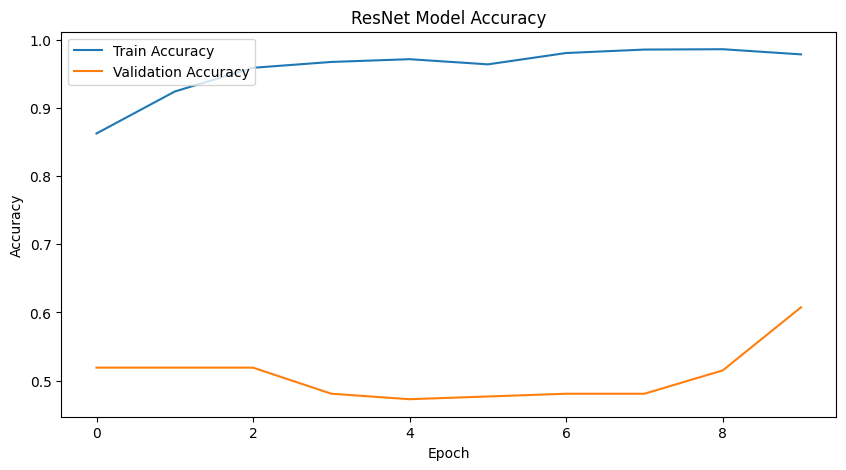

16/16 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step


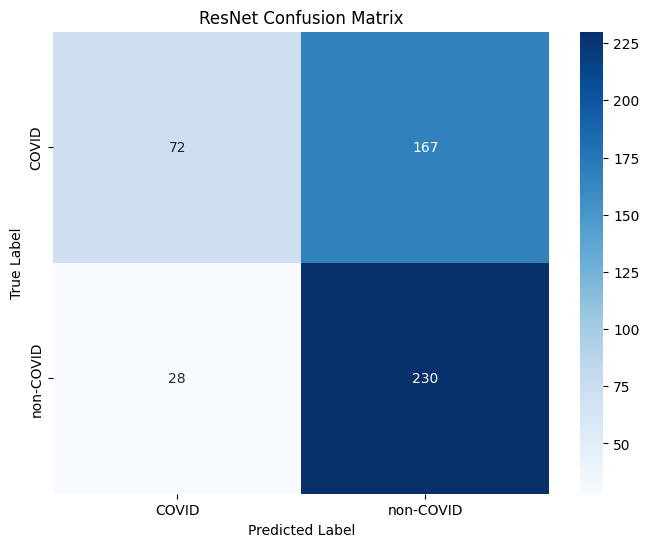

Classification Report:
              precision    recall  f1-score   support

       COVID       0.72      0.30      0.42       239
   non-COVID       0.58      0.89      0.70       258

    accuracy                           0.61       497
   macro avg       0.65      0.60      0.56       497
weighted avg       0.65      0.61      0.57       497

Specificity: 0.3013
Selectivity: 0.8915
Model saved successfully.


In [18]:
# Evaluate ResNet Model
evaluate_model(resnet_model, history_resnet, X_val, y_val_encoded, "ResNet")

# Save the ResNet model
resnet_model.save('resnet_covid_model.keras')
print("Model saved successfully.")

In [12]:
# Function to build EfficientNet model
def build_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    return model

# Train EfficientNet Model
efficientnet_model = build_efficientnet()
efficientnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

history_efficientnet = efficientnet_model.fit(data_gen.flow(X_train, y_train_encoded, batch_size=32),
                                              validation_data=(X_val, y_val_encoded), epochs=10)

Epoch 1/10


C:\Users\Paidi Madhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 526s 7s/step - accuracy: 0.7386 - loss: 0.5473 - val_accuracy: 0.4809 - val_loss: 0.6944
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 459s 7s/step - accuracy: 0.8930 - loss: 0.2591 - val_accuracy: 0.4809 - val_loss: 0.6943
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 463s 7s/step - accuracy: 0.9278 - loss: 0.1879 - val_accuracy: 0.4809 - val_loss: 0.6937
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 458s 7s/step - accuracy: 0.9434 - loss: 0.1485 - val_accuracy: 0.4809 - val_loss: 0.6939
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 525s 8s/step - accuracy: 0.9534 - loss: 0.1074 - val_accuracy: 0.4809 - val_loss: 0.6943
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 530s 8s/step - accuracy: 0.9632 - loss: 0.0873 - val_accuracy: 0.4728 - val_loss: 0.6931
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 534s 9s/step - accuracy: 0.9704 - loss: 0.0800 - val_accuracy: 0.4366 - val_loss: 0.7391
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 524s 8s/step - accuracy: 0.9771 - loss: 0.0643 - val_accuracy: 0.3823 - val_loss: 0.

In [13]:
train_accuracy = history_efficientnet.history['accuracy']
val_accuracy = history_efficientnet.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

Training Accuracy: 0.9788306355476379
Validation Accuracy: 0.6177062392234802


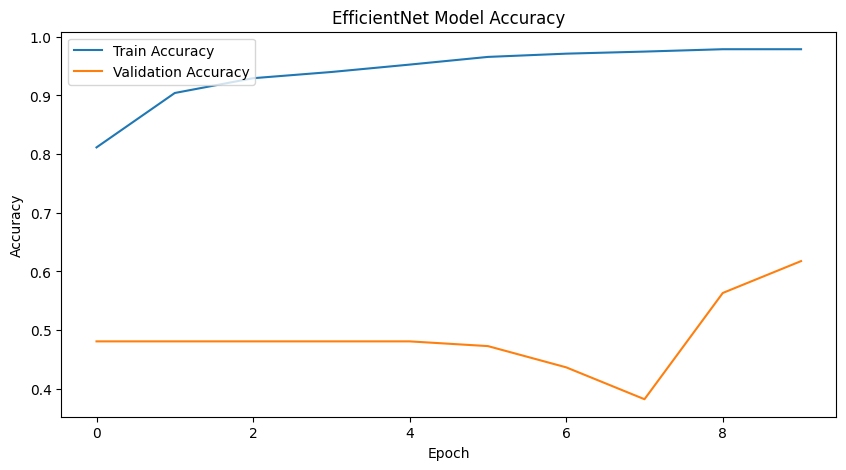

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step


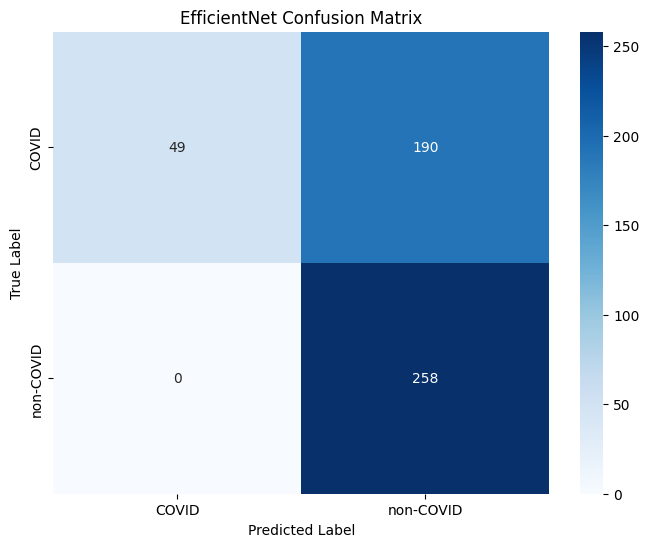

Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      0.21      0.34       239
   non-COVID       0.58      1.00      0.73       258

    accuracy                           0.62       497
   macro avg       0.79      0.60      0.54       497
weighted avg       0.78      0.62      0.54       497

Specificity: 0.2050
Selectivity: 1.0000
Model saved successfully.


In [14]:
# Evaluate EfficientNet Model
evaluate_model(efficientnet_model, history_efficientnet, X_val, y_val_encoded, "EfficientNet")

# Save the EfficientNet model
efficientnet_model.save('efficientnet_covid_model.keras')
print("Model saved successfully.")

In [8]:
# Function to build VGG19 model
def build_vgg19():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    return model

# Train VGG19 Model
vgg19_model = build_vgg19()
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

history_vgg19 = vgg19_model.fit(data_gen.flow(X_train, y_train_encoded, batch_size=32),
                                 validation_data=(X_val, y_val_encoded), epochs=10)

Epoch 1/10


C:\Users\Paidi Madhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 2604s 41s/step - accuracy: 0.5125 - loss: 0.7082 - val_accuracy: 0.7827 - val_loss: 0.5088
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2027s 33s/step - accuracy: 0.7108 - loss: 0.5863 - val_accuracy: 0.8330 - val_loss: 0.4252
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2550s 41s/step - accuracy: 0.7711 - loss: 0.4686 - val_accuracy: 0.7948 - val_loss: 0.4796
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3133s 51s/step - accuracy: 0.8199 - loss: 0.4195 - val_accuracy: 0.8571 - val_loss: 0.3573
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3962s 64s/step - accuracy: 0.8554 - loss: 0.3514 - val_accuracy: 0.8451 - val_loss: 0.4334
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5584s 91s/step - accuracy: 0.8518 - loss: 0.3659 - val_accuracy: 0.8692 - val_loss: 0.3042
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4760s 76s/step - accuracy: 0.8946 - loss: 0.2776 - val_accuracy: 0.8712 - val_loss: 0.3283
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1887s 30s/step - accuracy: 0.8929 - loss: 0.2875 - val_accuracy: 0.790

In [9]:
train_accuracy = history_vgg19.history['accuracy']
val_accuracy = history_vgg19.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

Training Accuracy: 0.8966733813285828
Validation Accuracy: 0.8832998275756836


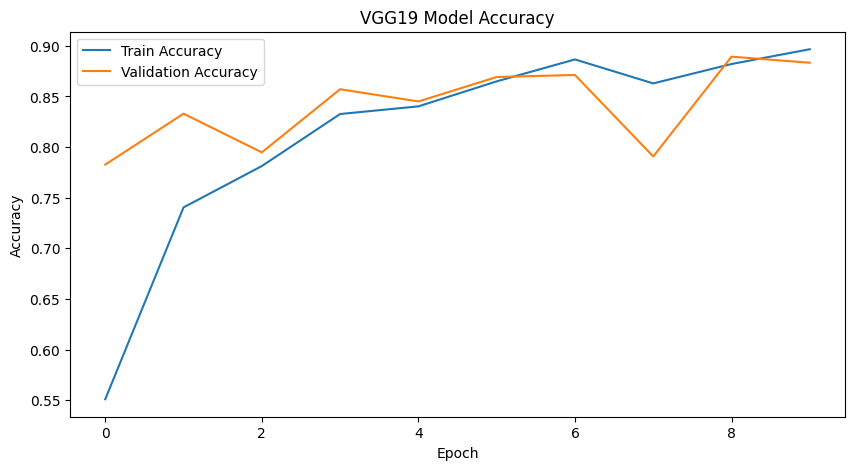

16/16 ━━━━━━━━━━━━━━━━━━━━ 409s 25s/step


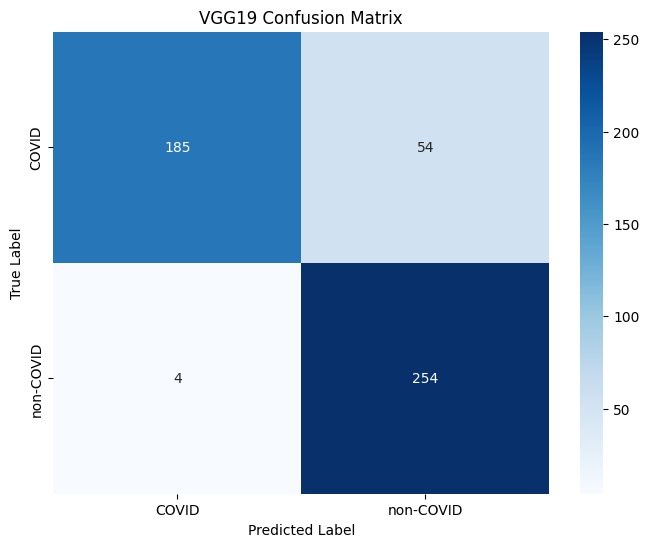

Classification Report:
              precision    recall  f1-score   support

       COVID       0.98      0.77      0.86       239
   non-COVID       0.82      0.98      0.90       258

    accuracy                           0.88       497
   macro avg       0.90      0.88      0.88       497
weighted avg       0.90      0.88      0.88       497

Specificity: 0.7741
Selectivity: 0.9845
Model saved successfully.


In [10]:
# Evaluate VGG19 Model
evaluate_model(vgg19_model, history_vgg19, X_val, y_val_encoded, "VGG19")

# Save the VGG19 model
vgg19_model.save('vgg19_covid_model.keras')
print("Model saved successfully.")

In [9]:
# Function to build AlexNet model
def build_alexnet():
    model = Sequential()
    
    # 1st Convolutional Layer
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # 2nd Convolutional Layer
    model.add(Conv2D(256, kernel_size=(5, 5), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # 3rd, 4th, and 5th Convolutional Layers
    model.add(Conv2D(384, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    # Flatten the output to feed it into fully connected layers
    model.add(Flatten())
    
    # 1st Fully Connected Layer
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))  # Adding dropout for regularization
    
    # 2nd Fully Connected Layer
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))  # Adding dropout for regularization
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output layer
    
    return model

# Train AlexNet Model
alexnet_model = build_alexnet()
alexnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss=BinaryCrossentropy(), metrics=['accuracy'])

history_alexnet = alexnet_model.fit(data_gen.flow(X_train, y_train_encoded, batch_size=32),
                                    validation_data=(X_val, y_val_encoded), epochs=10)

C:\Users\Paidi Madhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\Paidi Madhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1106s 15s/step - accuracy: 0.5018 - loss: 0.6987 - val_accuracy: 0.5332 - val_loss: 0.6915
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1005s 15s/step - accuracy: 0.5232 - loss: 0.6930 - val_accuracy: 0.5191 - val_loss: 0.6923
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 717s 11s/step - accuracy: 0.4999 - loss: 0.6931 - val_accuracy: 0.4809 - val_loss: 0.6924
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 978s 15s/step - accuracy: 0.5141 - loss: 0.6919 - val_accuracy: 0.5493 - val_loss: 0.6665
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1059s 16s/step - accuracy: 0.6157 - loss: 0.6553 - val_accuracy: 0.7163 - val_loss: 0.5606
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 519s 6s/step - accuracy: 0.6591 - loss: 0.6179 - val_accuracy: 0.6680 - val_loss: 0.5860
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 446s 7s/step - accuracy: 0.7313 - loss: 0.5500 - val_accuracy: 0.6982 - val_loss: 0.5615
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 476s 7s/step - accuracy: 0.7000 - loss: 0.5858 - val_accuracy: 0.6419 - val_

In [10]:
train_accuracy = history_alexnet.history['accuracy']
val_accuracy = history_alexnet.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])

Training Accuracy: 0.7424395084381104
Validation Accuracy: 0.6941649913787842


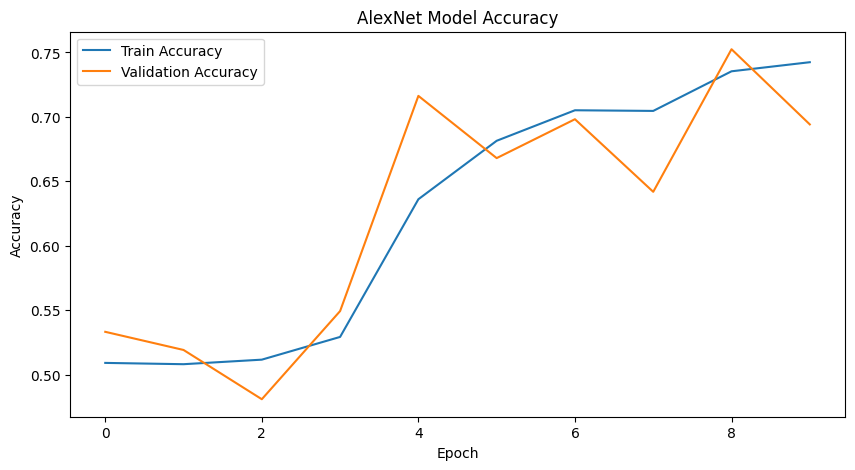

16/16 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step


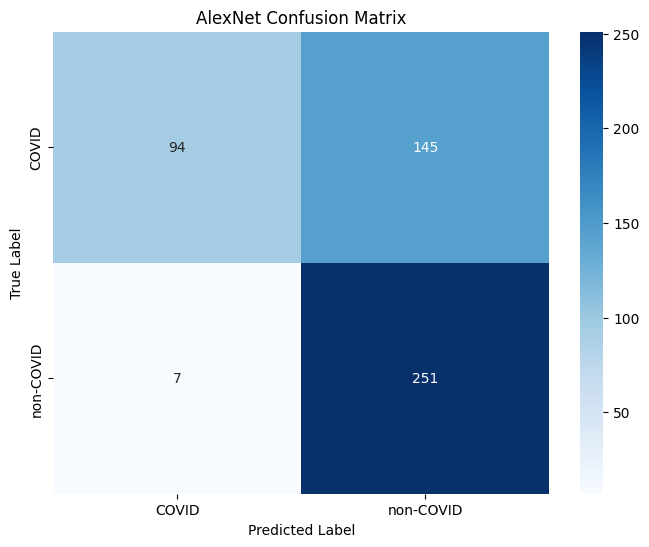

Classification Report:
              precision    recall  f1-score   support

       COVID       0.93      0.39      0.55       239
   non-COVID       0.63      0.97      0.77       258

    accuracy                           0.69       497
   macro avg       0.78      0.68      0.66       497
weighted avg       0.78      0.69      0.66       497

Specificity: 0.3933
Selectivity: 0.9729
Model saved successfully.


In [11]:
# Evaluate AlexNet Model
evaluate_model(alexnet_model, history_alexnet, X_val, y_val_encoded, "AlexNet")

# Save the AlexNet model
alexnet_model.save('alexnet_covid_model.keras')
print("Model saved successfully.")